In [1]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import random
random.seed(1447)

In [2]:
#red each sheet from excel DATA woork book 
file_path = r"C:\Users\OMEN\Desktop\Optimisation\Optimisation_flux_matier\data.xlsx"


try:
    with open(file_path):
        pass
except FileNotFoundError:
    print(f"File not found: {file_path}")
    
# Read Excel sheets
try:
    manvar_costs = pd.read_excel(file_path, sheet_name="variable_costs", index_col=0)
    freight_costs = pd.read_excel(file_path, sheet_name="freight_costs", index_col=0)
    var_cost = freight_costs/1000 + manvar_costs 
    fixed_costs  = pd.read_excel(file_path, sheet_name="fixed_cost", index_col=0)
    cap  = pd.read_excel(file_path, sheet_name="capacity", index_col=0)
    demand = pd.read_excel(file_path, sheet_name="demand", index_col=0)
except FileNotFoundError:
    print(f"Error reading Excel file: {file_path}")

# filli the missing value white 0

In [7]:
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
print(plant_name)
prod_name = [(i,j) for i in loc for j in loc]   

[('USA', 'LOW'), ('GERMANY', 'LOW'), ('JAPAN', 'LOW'), ('BRAZIL', 'LOW'), ('INDIA', 'LOW'), ('USA', 'HIGH'), ('GERMANY', 'HIGH'), ('JAPAN', 'HIGH'), ('BRAZIL', 'HIGH'), ('INDIA', 'HIGH')]


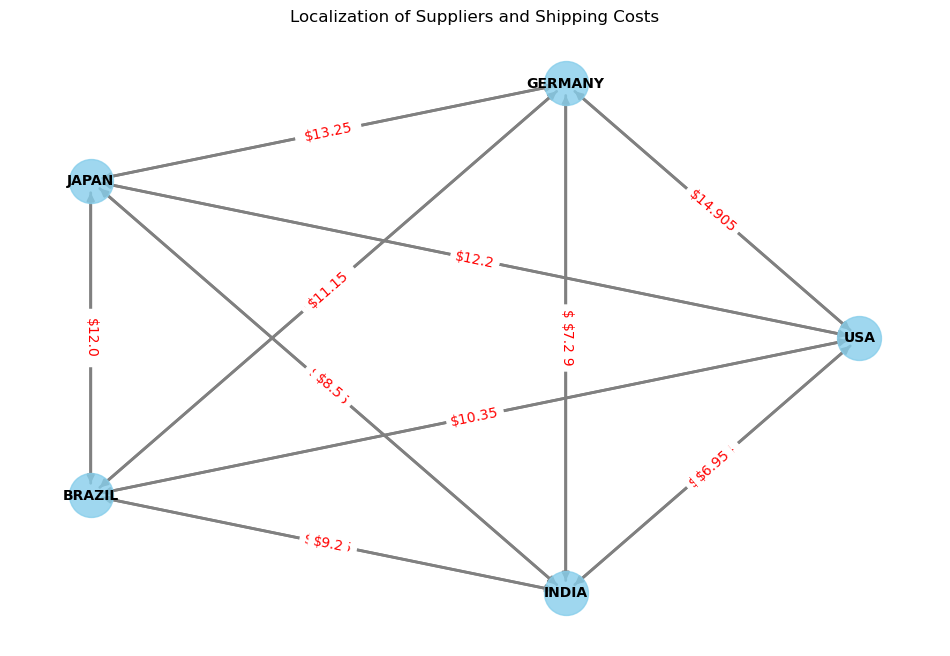

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Sample data (replace this with your actual data)
shipping_costs = {
    'USA': {'GERMANY': 13.75, 'JAPAN': 13.1, 'BRAZIL': 14.3, 'INDIA': 13.254},
    'GERMANY': {'USA': 14.905, 'JAPAN': 14.231, 'BRAZIL': 15.892, 'INDIA': 14.439},
    'JAPAN': {'USA': 12.2, 'GERMANY': 13.25, 'BRAZIL': 16.23, 'INDIA': 12.05},
    'BRAZIL': {'USA': 10.35, 'GERMANY': 11.15, 'JAPAN': 12.0, 'INDIA': 12.25},
    'INDIA': {'USA': 6.95, 'GERMANY': 7.2, 'JAPAN': 8.5, 'BRAZIL': 9.2}
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each location
for location in shipping_costs.keys():
    G.add_node(location)

# Add edges with weights representing shipping costs
for source, targets in shipping_costs.items():
    for target, cost in targets.items():
        G.add_edge(source, target, weight=cost)

# Get node positions for plotting
pos = nx.circular_layout(G)

# Extract edge weights for labels
edge_labels = {(source, target): f"${cost}" for source, targets in shipping_costs.items() for target, cost in targets.items()}

# Plotting
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Localization of Suppliers and Shipping Costs')
plt.axis('off')
plt.show()

In [5]:
pip install pulp

In [9]:
# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])                                                 
                                                       
# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool01 = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['Plant Opening'])
df_bool01

Status: Optimal
Total Costs: 65,118,000 ($/Month)


,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


In [10]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [11]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize

# Define Decision Variables
locations = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
sizes = ['LOW', 'HIGH']
plants = [(loc, size) for loc in locations for size in sizes]
production_pairs = [(i, j) for i in locations for j in locations]

# Initialize Model
model = LpProblem("Plant Location Model", LpMinimize)

# Create Decision Variables
x = LpVariable.dicts("production_", production_pairs, lowBound=0, cat='Continuous')
y = LpVariable.dicts("plant_", plants, cat='Binary')

# Define Objective Function
model += lpSum(fixed_costs.loc[i, s] * y[(i, s)] * 1000 for s in sizes for i in locations) \
         + lpSum(var_cost.loc[i, j] * x[(i, j)] for i in locations for j in locations)

# Add Constraints
for j in locations:
    model += lpSum(x[(i, j)] for i in locations) == demand.loc[j, 'Demand']
for i in locations:
    model += lpSum(x[(i, j)] for j in locations) <= lpSum(cap.loc[i, s] * y[(i, s)] * 1000 for s in sizes)

# Solve Model
model.solve()

# Display Results
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool = pd.DataFrame(data=[y[plant].varValue for plant in plants],
                       index=[f"{loc}-{size}" for size in sizes for loc in locations],
                       columns=['Plant Opening'])
print(df_bool)

Status: Optimal
Total Costs: 65,118,000 ($/Month)
              Plant Opening
USA-LOW       0.0          
GERMANY-LOW   0.0          
JAPAN-LOW     0.0          
BRAZIL-LOW    0.0          
INDIA-LOW     0.0          
USA-HIGH      1.0          
GERMANY-HIGH  0.0          
JAPAN-HIGH    1.0          
BRAZIL-HIGH   1.0          
INDIA-HIGH    1.0          


c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


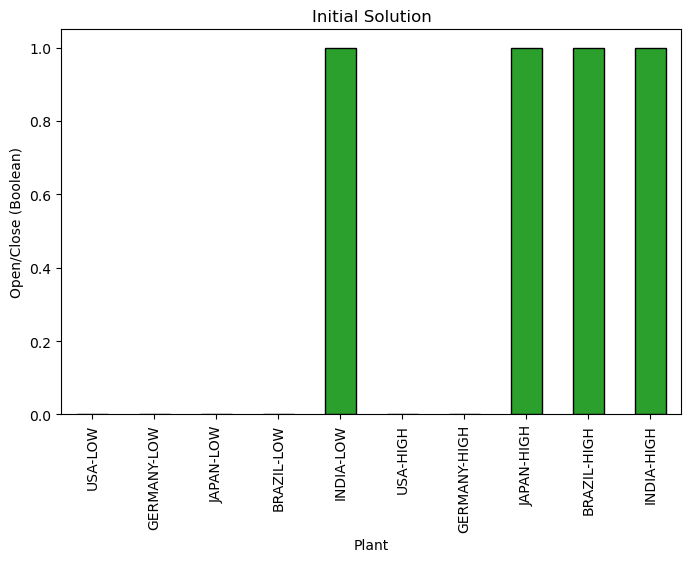

In [17]:
cap_plot = cap.copy()

ax = df_bool01.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

In [18]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]   

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_", 
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])                                                 
    # Solve Model
    model.solve()
    
    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

In [19]:
# Normal Distribution
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data01 = demand.reset_index()
# Demand 
CV = 0.5
markets = data01['(Units/month)'].values
for col, value in zip(markets, data01['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('df_demand-{}PC.xlsx'.format(int(CV * 100)))
    
df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,2950240,105391,2749252,149415,322176
1,2,4458938,107887,792618,29859,190870
2,3,6906204,95520,1248197,186202,310413
3,4,2523398,49938,539360,189431,24546


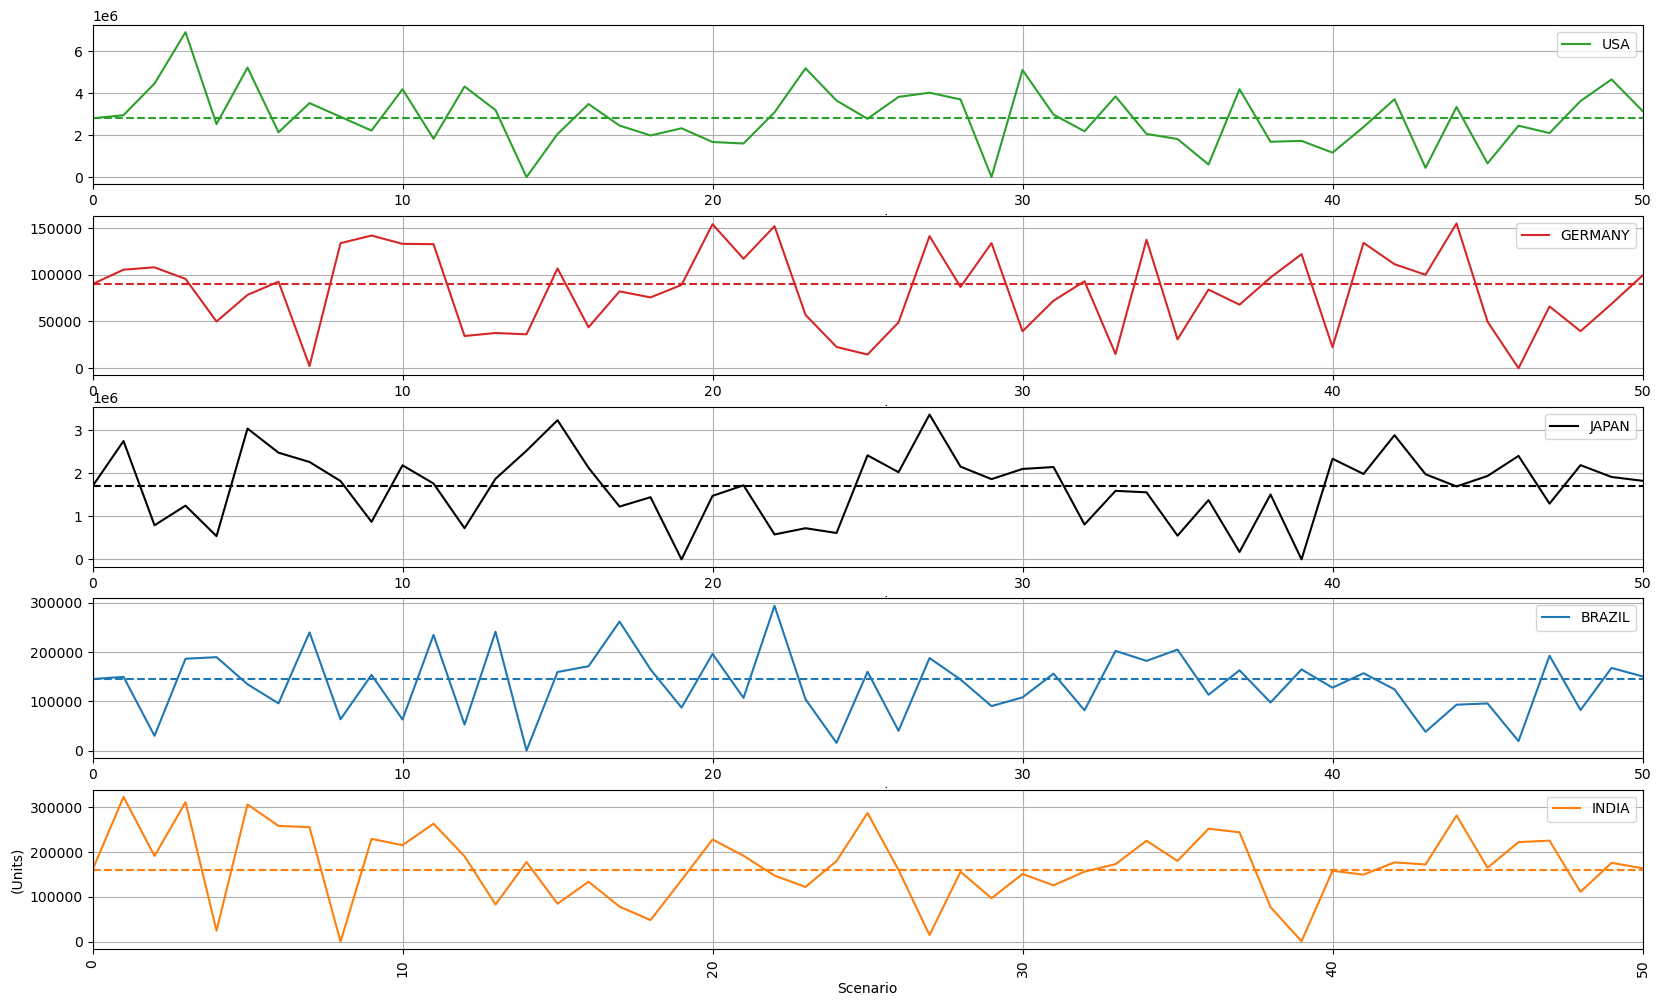

In [20]:
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

In [22]:
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['INITIAL'])
df_bool.head()

demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario 
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)    
    
    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel('boolean-{}PC.xlsx'.format(int(CV * 100)))
# Other Results
df_bool.head()

c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\AMD\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are no

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
JAPAN-LOW,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
BRAZIL-LOW,0,1,1,0,1,1,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,0,1,1
INDIA-LOW,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1


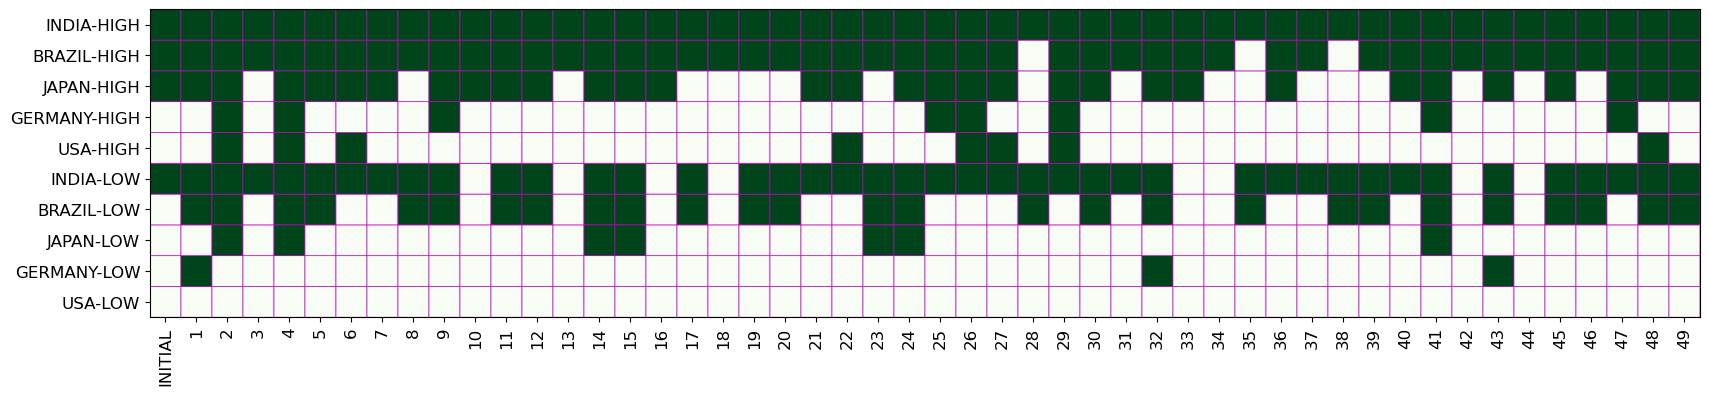

In [28]:
# Plot the Grid
plt.figure(figsize = (20,4))
plt.pcolor( df_bool, cmap = 'Greens', edgecolors='m', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.show()

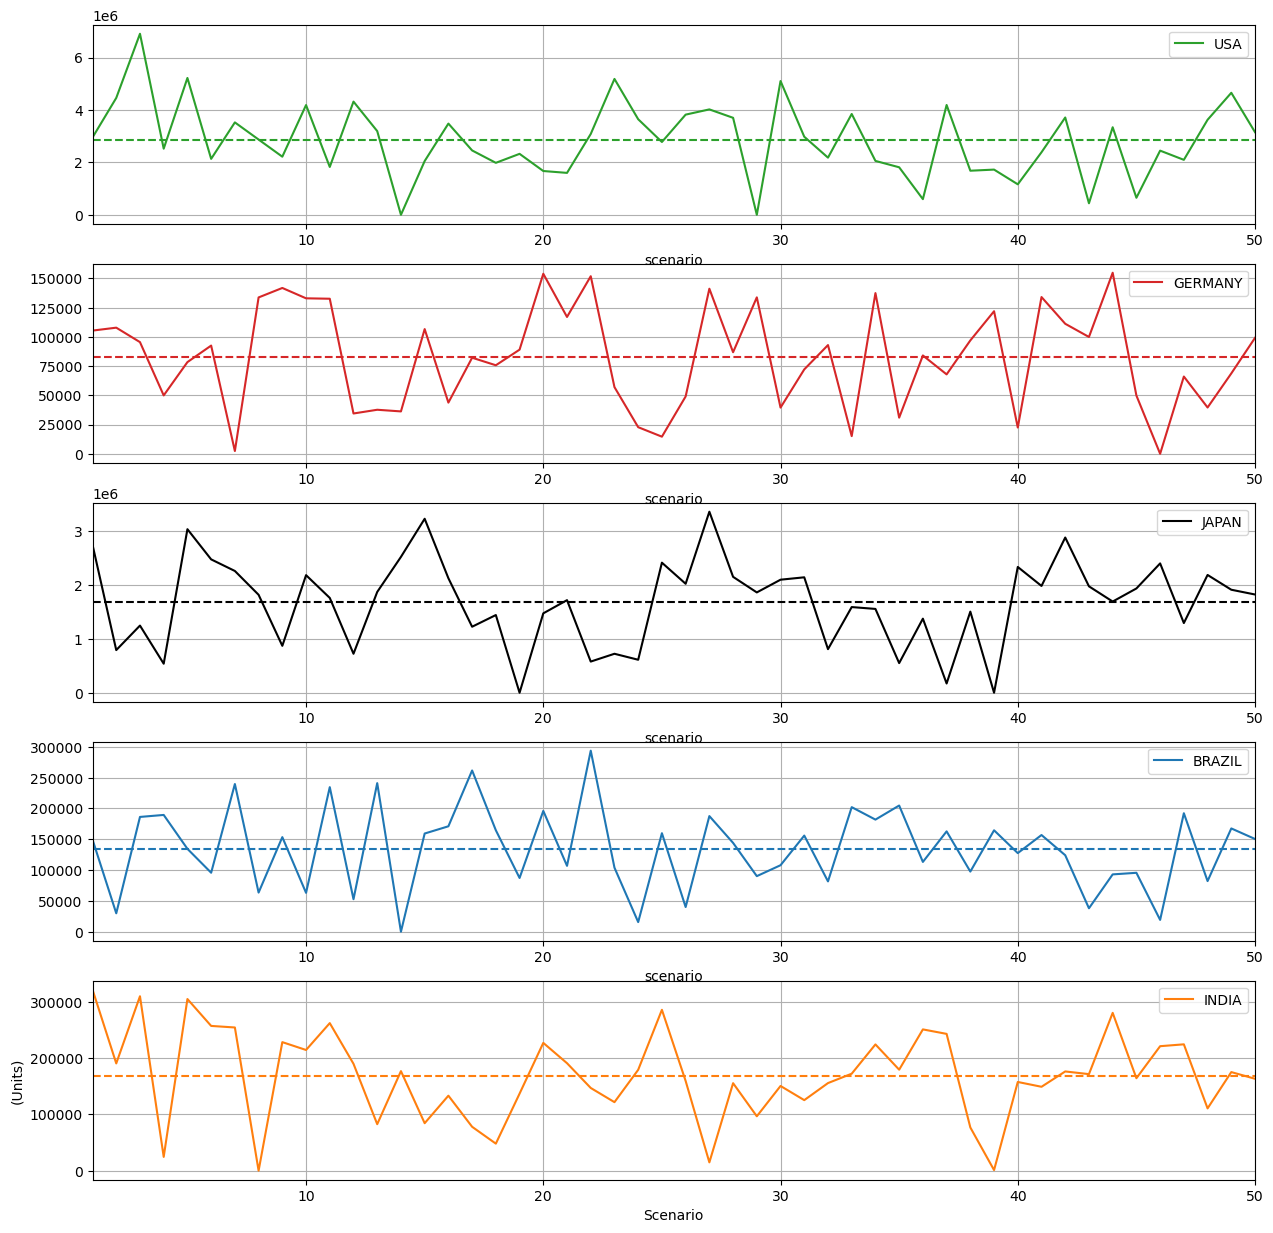

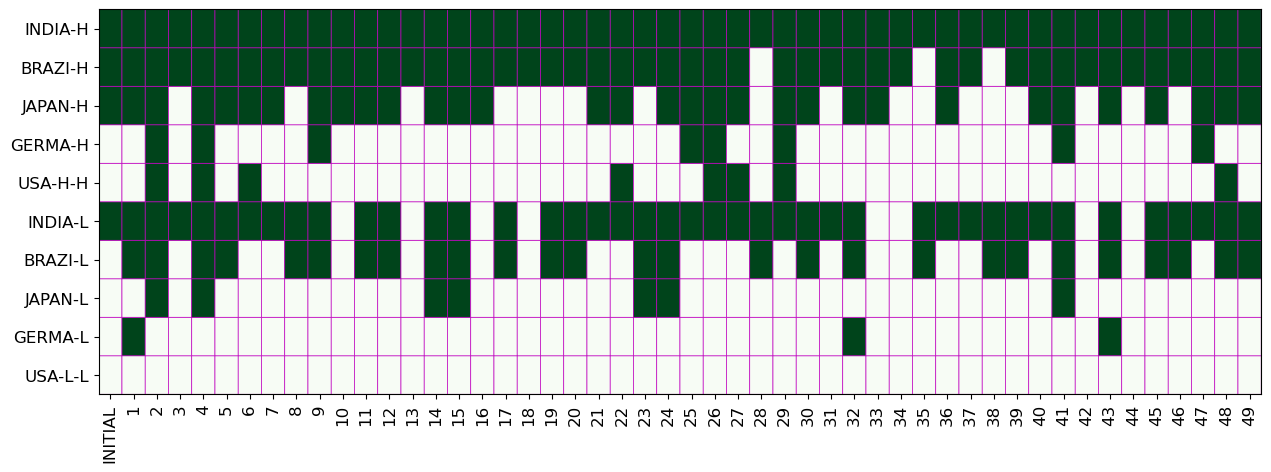

In [29]:
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(15, 15), xlim=[1,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].mean(), color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')

# add the scenario plot
plt.figure(figsize=(15, 5))
plt.pcolor(df_bool, cmap = 'Greens', edgecolors='m', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], [d[0:5]+ '-H' * ('HIGH' in d) + '-L' * ('LOW' in d) for d in df_bool.index], fontsize=12)
plt.xticks(rotation=90)
plt.show()

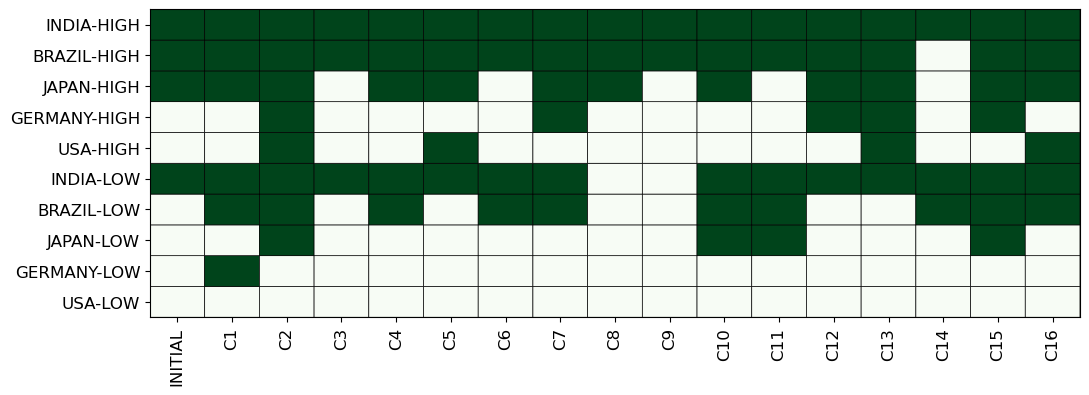

In [31]:
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Greens', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

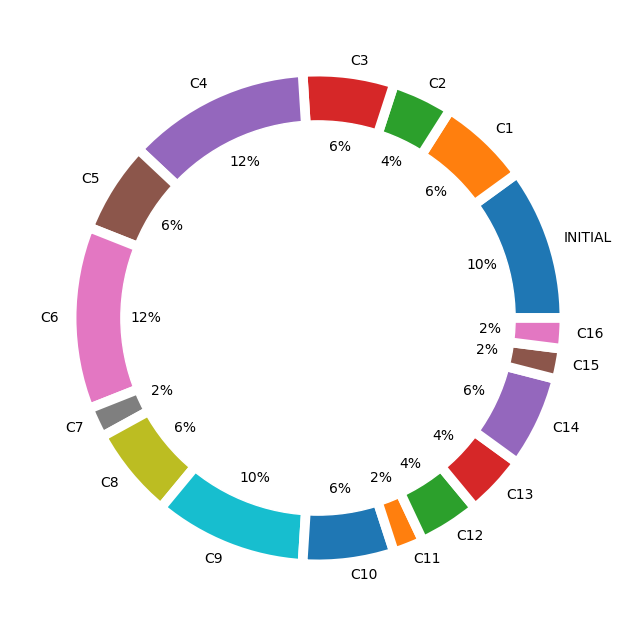

In [33]:
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2]!=df_unique[col1]).sum()==0:
            count += 1
    COL_NUMBER.append(count)
df_comb = pd.DataFrame({'column':COL_NAME, 'count':COL_NUMBER}).set_index('column')

my_circle = plt.Circle( (0,0), 0.8, color='white')
df_comb.plot.pie(figsize=(8, 8), x='column', y='count', legend= False, pctdistance=0.7,
                                          autopct='%1.0f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
# plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle) 
plt.axis('off')
plt.show()